# Calculation of B.1.1.7 (British Variant) in Denmark & Future Estimates

The following consists of two fits to Danish Covid-19 test and sequencing data, with the aim of determining most precisely the picture for the coming months time. It is based on the combination of results from two fits:


### Fit of B.1.1.7 fraction:
The first fit determins the development in the **fraction** of B.1.1.7 $f_B$ among the positive tests. This fraction is **independent** of the variations in the contact number (factoring out this part of the problem), and from this one can also determine how much more infectious B.1.1.7 is. The B.1.1.7 data is modelled as:

$$f_{B}(t) = \frac{f_{B}(t_0) ~ \exp(t/\tau_{f_B})}{(1-f_{B}(t_0)) ~+~ f_{B}(t_0) \exp(t/\tau_{f_B})}$$

The data is from the sequencing (WGS) of positive samples. It should be **clearly stated** that these samples are **NOT** guaranteed to be random, which renders the result potentially biased. We consider the daily statistics (which is low) with a binned likelihood fit.


### Fit to current test & positive numbers:
The second fit determins the parameters of the current (rather stable) situation, that is the number of daily positives $P_i$, which is scaled in relation to the number of daily tests $T_i$ as $(T_i/\bar{T})^{0.7}$, as the number of positives does not grow linearly with number of tests. From this fit one can also extract the contact number. Based on the extension of the lockdown to the 7th of February, and therefore assuming an unchanged contact number, estimates of the coming month can be done.

The fit model to the scaled positives is: $SP(t) = SP(t_0) ~ R^{(t-t_0)/t_G}$, where $t_G = 4.7$ days.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
# from scipy.optimize import curve_fit, minimize
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = True

***

# Fit of B.1.1.7 fraction:

## Read the data:

The data - which is based on single cases - is organised into a daily count of positives with and without B.1.1.7.

In [2]:
# table = pd.read_excel('2021-01-17_CAHM.xlsx')
# table = pd.read_excel('2021-01-24_CAHM.xlsx')
# table = pd.read_excel('2021-01-27_N501Y.xlsx')
#table = pd.read_excel('2021-01-28_N501Y.xlsx')
table = pd.read_excel('2021-02-09_WGS_Data.xlsx')


Nb117  = []
Ntotal = []
dates  = []

for date, data in table.groupby('date_sampling'): 
    Nb117.append( len(data['clade'][data['clade'] == '20I/501Y.V1']) ) # determine number segmented to clade given day
    Ntotal.append( len(data['clade']) )                                # determine number segmented totally
    dates.append(date)                                                 # Store dates, sorted by group

# Set number of days to include in the fit (i.e. days back in time):
Ndays = 60

# Set the average time between generation (in days):
tG = 4.7

# Get numpy arrays of the counts and the fraction of B.1.1.7:
Nb117, Ntotal = np.array(Nb117), np.array(Ntotal)
frac = Nb117/Ntotal

for i in range(len(frac)-Ndays,len(frac)) :
    print(f"  Days back in time: {len(frac)-i:2d}     date: {dates[i]}   N(B117) = {Nb117[i]:3.0f}  Ntotal = {Ntotal[i]:4.0f}   frac = {frac[i]:5.3f}")

  Days back in time: 60     date: 2020-12-06 00:00:00   N(B117) =   0  Ntotal =  302   frac = 0.000
  Days back in time: 59     date: 2020-12-07 00:00:00   N(B117) =   1  Ntotal =  286   frac = 0.003
  Days back in time: 58     date: 2020-12-08 00:00:00   N(B117) =   0  Ntotal =  804   frac = 0.000
  Days back in time: 57     date: 2020-12-09 00:00:00   N(B117) =   1  Ntotal =  397   frac = 0.003
  Days back in time: 56     date: 2020-12-10 00:00:00   N(B117) =   0  Ntotal =  220   frac = 0.000
  Days back in time: 55     date: 2020-12-11 00:00:00   N(B117) =   0  Ntotal =  678   frac = 0.000
  Days back in time: 54     date: 2020-12-12 00:00:00   N(B117) =   3  Ntotal =  271   frac = 0.011
  Days back in time: 53     date: 2020-12-13 00:00:00   N(B117) =   8  Ntotal =  667   frac = 0.012
  Days back in time: 52     date: 2020-12-14 00:00:00   N(B117) =   3  Ntotal =  915   frac = 0.003
  Days back in time: 51     date: 2020-12-15 00:00:00   N(B117) =   3  Ntotal =  690   frac = 0.004


## Define fitting function and model:

In [3]:
# Fitting function:
def func_logistic(t, frac_t0, tau) :
    return frac_t0*np.exp(t/tau) / ((1-frac_t0) + frac_t0*np.exp(t/tau))

# Binned likelihood fit model:
def model_bllh(x, N_obs, frac_t0, tau):
    N_exp = func_logistic(x, frac_t0, tau) * Ntotal[-Ndays:]
    return -2*sum( stats.poisson.logpmf( N_obs, N_exp ) )

In [4]:
# Fit the fraction:
minuit_obj = Minuit(lambda frac_t0, tau: model_bllh(np.arange(-len(frac[-Ndays:]), 0), Nb117[-Ndays:], frac_t0, tau), 
                    frac_t0=0.26, tau=12.0, error_frac_t0 = 0.05, error_tau=1.0, errordef=0.5)
minuit_obj.errordef = 0.5
minuit_obj.migrad()   
if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The Likelihood fit DID NOT converge!!!")

# Record the fit results and print them:
frac_t0_fit, dfrac_t0_fit = minuit_obj.params[0].value, minuit_obj.params[0].error
tau_fit, dtau_fit         = minuit_obj.params[1].value, minuit_obj.params[1].error
factor_B117 = np.e**(tG/tau_fit)
efactor_B117 = np.e**(tG/tau_fit) * (tG/tau_fit**2) * dtau_fit
print(f"   Frac_t0: {frac_t0_fit:5.3f} +- {dfrac_t0_fit:5.3f}   Tau: {tau_fit:5.1f} +- {dtau_fit:3.1f}    factor_B117 = {factor_B117:5.3f} +- {efactor_B117:5.3f}") 

   Frac_t0: 0.251 +- 0.006   Tau:  12.4 +- 0.3    factor_B117 = 1.460 +- 0.011


In [12]:
Ndays2 = 30

# Binned likelihood fit model:
def model_bllh2(x, N_obs, frac_t0, tau):
    N_exp = func_logistic(x, frac_t0, tau) * Ntotal[-Ndays2:]
    return -2*sum( stats.poisson.logpmf( N_obs, N_exp ) )

# Fit the fraction:
minuit_obj2 = Minuit(lambda frac_t0, tau: model_bllh2(np.arange(-len(frac[-Ndays2:]), 0), Nb117[-Ndays2:], frac_t0, tau), 
                    frac_t0=0.26, tau=12.0, error_frac_t0 = 0.05, error_tau=1.0, errordef=0.5)
minuit_obj2.errordef = 0.5
minuit_obj2.migrad()   
if (not minuit_obj2.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The Likelihood fit DID NOT converge!!!")

# Record the fit results and print them:
frac_t0_fit2, dfrac_t0_fit2 = minuit_obj2.params[0].value, minuit_obj2.params[0].error
tau_fit2, dtau_fit2         = minuit_obj2.params[1].value, minuit_obj2.params[1].error
factor_B117 = np.e**(tG/tau_fit2)
efactor_B117 = np.e**(tG/tau_fit2) * (tG/tau_fit2**2) * dtau_fit2
print(f"   Frac_t0: {frac_t0_fit2:5.3f} +- {dfrac_t0_fit2:5.3f}   Tau: {tau_fit2:5.2f} +- {dtau_fit2:4.2f}    factor_B117 = {factor_B117:5.3f} +- {efactor_B117:5.3f}") 

   Frac_t0: 0.255 +- 0.008   Tau: 12.19 +- 0.40    factor_B117 = 1.470 +- 0.019


## Plot the fit result and extrapolate into future:

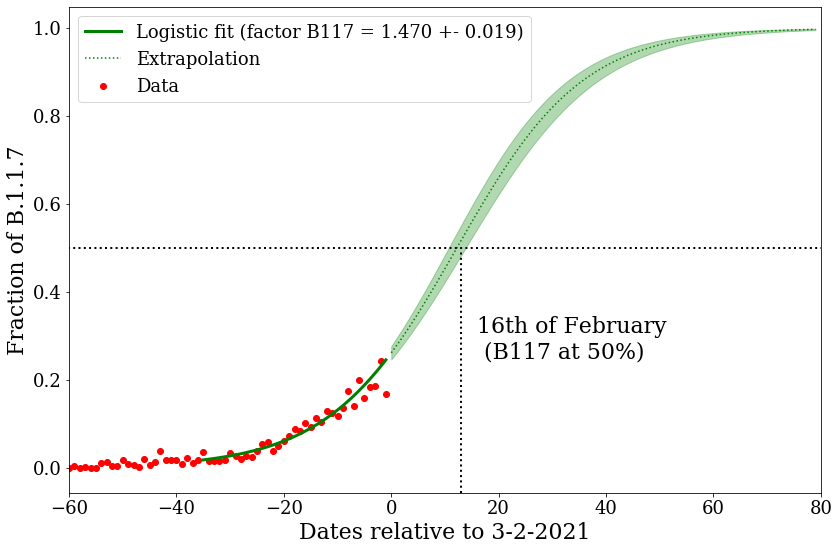

In [6]:
Nsig = 2.0      # Number of sigmas to change parameters for error band!
Nfuture = 80

plt.figure(figsize=(12,8))
plt.scatter(np.arange(-len(frac),0), frac, color='r', label='Data')

#plt.plot(np.arange(-Ndays,0),  func_logistic(np.arange(-Ndays,0),  *[frac_t0_fit, tau_fit]), label='Logistic fit (60 days)', color="blue", linewidth=3)
#plt.plot(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit, tau_fit]), label='Extrapolation (factor_B117 = 1.460 +- 0.011)', color="blue", linestyle=":")
#plt.plot(np.arange(-Ndays2,0), func_logistic(np.arange(-Ndays2,0), *[frac_t0_fit2, tau_fit2]), label='Logistic fit (30 days)', color="green", linewidth=3)
#plt.plot(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit2, tau_fit2]), label='Extrapolation (factor_B117 = 1.470 +- 0.019)', color="green", linestyle=":")
plt.plot(np.arange(-Ndays2,0), func_logistic(np.arange(-Ndays2,0), *[frac_t0_fit2, tau_fit2]), label='Logistic fit (factor B117 = 1.470 +- 0.019)', color="green", linewidth=3)
plt.plot(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit2, tau_fit2]), label='Extrapolation', color="green", linestyle=":")
plt.legend()

# Plot an "envelope" of possible predictions:
#plt.plot(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
#plt.plot(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
#plt.fill_between(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), color='blue', alpha=0.3)

#plt.plot(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit2+Nsig*dfrac_t0_fit2, tau_fit2-Nsig*dtau_fit2]), label='LLH', color="green", linestyle=":")
#plt.plot(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit2-Nsig*dfrac_t0_fit2, tau_fit2+Nsig*dtau_fit2]), label='LLH', color="green", linestyle=":")
plt.fill_between(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit2+Nsig*dfrac_t0_fit2, tau_fit2-Nsig*dtau_fit2]), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit2-Nsig*dfrac_t0_fit2, tau_fit2+Nsig*dtau_fit2]), color='green', alpha=0.3)

# Show estimate of "British take-over":
plt.axhline(y=0.5,  xmin=-Ndays, xmax=Nfuture, color='black', linewidth=2.0, linestyle="dotted")
plt.axvline(x=13.0, ymin=0.0,    ymax=0.5,     color='black', linewidth=2.0, linestyle="dotted")
plt.text(16.0, 0.25, "16th of February\n (B117 at 50%)", fontsize=22)

plt.xlim(-Ndays,Nfuture)
plt.ylabel('Fraction of B.1.1.7', fontsize=22)
plt.xlabel('Dates relative to '+str(dates[-1].day)+'-'+str(dates[-1].month)+'-'+str(dates[-1].year), fontsize=22 )

plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_FitOfB117fraction_SingleGraph.pdf")

## Discussion of "lifetime":

The "lifetime" $\tau = 11.8 \pm 0.3$ days from the fit suggests, that it takes about 11.8 days for B.1.1.7 to grow by a factor $e = 2.7$, and thus given a generation time of $t_G = 4.7~\mbox{days}$, that the infection rate from B.1.1.7 is the following factor greater than the current dominant variant in Denmark:

$$\tau = 11.8~\mbox{days} \longrightarrow \beta_{B117} = \beta \times e^{4.7/11.8} = \beta \times 1.49$$

In [7]:
factor_B117 = np.e**(tG/tau_fit2)
efactor_B117 = np.e**(tG/tau_fit2) * (tG/tau_fit2**2) * dtau_fit2
print(f"  factor_B117 = {factor_B117:4.2f} +- {efactor_B117:4.2f}")

  factor_B117 = 1.49 +- 0.02


### Calculate systematic variations with fitting range:

In [8]:
for iNdays in range(Ndays-7) :
    
    # Binned likelihood fit model:
    def model_bllh3(x, N_obs, frac_t0, tau):
        N_exp = func_logistic(x, frac_t0, tau) * Ntotal[-Ndays+iNdays:]
        return -2*sum( stats.poisson.logpmf( N_obs, N_exp ) )
    
    minuit_obj3 = Minuit(lambda frac_t0, tau: model_bllh3(np.arange(-len(frac[-Ndays+iNdays:]), 0), Nb117[-Ndays+iNdays:], frac_t0, tau),
                         frac_t0=0.26, tau=12.0, error_frac_t0 = 0.05, error_tau=1.0, errordef=0.5)
    minuit_obj3.migrad()   
    if (not minuit_obj3.fmin.is_valid) :                                   # Check if the fit converged
        print("  WARNING: The Likelihood fit DID NOT converge!!!")

    # Record the fit results and print them:
    frac_t0_fit, dfrac_t0_fit = minuit_obj3.params[0].value, minuit_obj3.params[0].error
    tau_fit, dtau_fit         = minuit_obj3.params[1].value, minuit_obj3.params[1].error
    factor_B117 = np.e**(tG/tau_fit)
    efactor_B117 = np.e**(tG/tau_fit) * (tG/tau_fit**2) * dtau_fit
    print(f"   Ndays in fit: {Ndays-iNdays:2d}     Frac_t0: {frac_t0_fit:5.3f} +- {dfrac_t0_fit:5.3f}   Tau: {tau_fit:5.1f} +- {dtau_fit:3.1f}    factor_B117 = {factor_B117:4.2f} +- {efactor_B117:4.2f}")

   Ndays in fit: 60     Frac_t0: 0.251 +- 0.006   Tau:  12.4 +- 0.3    factor_B117 = 1.46 +- 0.01
   Ndays in fit: 59     Frac_t0: 0.250 +- 0.006   Tau:  12.4 +- 0.3    factor_B117 = 1.46 +- 0.01
   Ndays in fit: 58     Frac_t0: 0.250 +- 0.006   Tau:  12.4 +- 0.3    factor_B117 = 1.46 +- 0.01
   Ndays in fit: 57     Frac_t0: 0.249 +- 0.006   Tau:  12.5 +- 0.3    factor_B117 = 1.46 +- 0.01
   Ndays in fit: 56     Frac_t0: 0.249 +- 0.006   Tau:  12.5 +- 0.3    factor_B117 = 1.45 +- 0.01
   Ndays in fit: 55     Frac_t0: 0.248 +- 0.006   Tau:  12.6 +- 0.3    factor_B117 = 1.45 +- 0.01
   Ndays in fit: 54     Frac_t0: 0.247 +- 0.006   Tau:  12.7 +- 0.3    factor_B117 = 1.45 +- 0.01
   Ndays in fit: 53     Frac_t0: 0.248 +- 0.007   Tau:  12.6 +- 0.3    factor_B117 = 1.45 +- 0.01
   Ndays in fit: 52     Frac_t0: 0.250 +- 0.007   Tau:  12.4 +- 0.3    factor_B117 = 1.46 +- 0.01
   Ndays in fit: 51     Frac_t0: 0.249 +- 0.007   Tau:  12.5 +- 0.3    factor_B117 = 1.46 +- 0.01
   Ndays in fit: 50 

***

# Fit to current test & positive numbers:

In [9]:
# Define ranges, fitting function, and model:
Plot_StartDay = 1
Plot_EndDay   = 53
Fit_StartDay  = 2
Fit_EndDay    = 52
day1jan       = np.arange(Plot_StartDay, Plot_EndDay)
day1jan_fit   = np.arange(Fit_StartDay, Fit_EndDay)
day_extrapol  = np.arange(Fit_EndDay+1, Fit_EndDay+81)
day_all       = np.arange(Fit_StartDay, Fit_EndDay+81)
Npoints = len(day1jan_fit)

## Read the data:

In [10]:
data_posi = pd.read_csv("./Data-epidemiologisk-rapport-22022021/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
data_test = pd.read_csv("./Data-epidemiologisk-rapport-22022021/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

# All of Denmark
Nposi_all = data_posi.loc["2020-12-31":"2021-02-21"].sum(axis=1)
eNposi_all = np.sqrt(Nposi_all)
Ntest_all = data_test.loc["2020-12-31":"2021-02-21"].sum(axis=1)
eNtest_all = np.sqrt(Ntest_all)
day  = np.arange(1,len(Nposi_all)+1)

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = 0 #-0.56 #-0.6         # Power in power law for the increase in positives with increase in tests.
#SystError = 0.00075   # To account for larger uncertainties on fraction positives than simply the statistical.
SystError = 0.000   # To account for larger uncertainties on fraction positives than simply the statistical.

nAveDailyTests_all = Ntest_all.mean()
print("Average number of PCR tests: ", nAveDailyTests_all)
fPos_all = Nposi_all / Ntest_all
efPos_all = np.sqrt(fPos_all*(1.0-fPos_all)/Ntest_all + SystError**2)
nPos_all  = Nposi_all                                * (Ntest_all / nAveDailyTests_all)**Power
enPos_all = np.sqrt(Ntest_all*fPos_all*(1-fPos_all)) * (Ntest_all / nAveDailyTests_all)**Power

# Correct for effects of weekdays, corrects from 2nd January forward:
frac = [-0.06712774, -0.06683944, -0.05014257, -0.03242197, -0.00406104, 0.12570817,  0.11575076]
frac_fra_lørdag = np.roll(frac, -3)

for i,x,dx in zip(np.arange(Fit_StartDay,Fit_StartDay+len(nPos_all[Fit_StartDay:Fit_EndDay])),nPos_all[Fit_StartDay:Fit_EndDay], enPos_all[Fit_StartDay:Fit_EndDay]):
    nPos_all[i] = x*(1+frac_fra_lørdag[i%7])
    enPos_all[i] = dx*(1+frac_fra_lørdag[i%7])
    
# Print the date used:
print(" Date      Ntest      Npositive      Npos(scaled+corrected)")
for i in range(len(Ntest_all)) :
    print(f"{i+1:4d}   {Ntest_all[i]:10d}  {Nposi_all[i]:8d}       {nPos_all[i]:8.0f}")

FileNotFoundError: [Errno 2] File ./Data-epidemiologisk-rapport-22022021/Municipality_cases_time_series.csv does not exist: './Data-epidemiologisk-rapport-22022021/Municipality_cases_time_series.csv'

## Fit the PCR test data (assuming no B117):

In [ ]:
# Exponential function with base Rt:
def func_Expo(x, N0, Rt, t0, tG) :
    # NOTE: tG = time_generation, i.e. average time between generations.
    return N0 * Rt**((x-t0)/tG)

# ChiSquare fit model:
def chi2_calc(N0, Rt, t0, tG) :
    y_fit = func_Expo(day1jan_fit, N0, Rt, t0, tG)
    chi2 = np.sum(((nPos_all[Fit_StartDay:Fit_EndDay] - y_fit) / enPos_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

minuit = Minuit(chi2_calc, N0=1000.0, Rt=0.9, t0=1.0, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit = minuit.values['N0'];       sigma_N0_fit = minuit.errors['N0']
Rt_fit = minuit.values['Rt'];       sigma_Rt_fit = minuit.errors['Rt']
t0_fit = minuit.values['t0'];       sigma_t0_fit = minuit.errors['t0']
tG_fit = minuit.values['tG'];       sigma_tG_fit = minuit.errors['tG']
print("  Rt fit = ", Rt_fit, "+-", sigma_Rt_fit)

# Calcuate fit quality:
Chi2_fit = minuit.fval       # The Chi2 value
Nvar = 3                     # Number of variables (tG is fixed!)
Ndof_fit = Npoints - Nvar    # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")

## Fit the PCR test data **including** B117 component:

In [ ]:
PowerB117 = factor_B117    # Value obtained from 30-day fit!

# Exponential function with base Rt:
def func_DoubleExpo(x, N0, Rt, t0, tG) :
    # NOTE: tG = time_generation, i.e. average time between generations.
    frac_B117 = func_logistic(x-33, *[frac_t0_fit, tau_fit])       # Offset of 33 days is to match B117 fit t0 scale!
    return N0 * ((1.0-frac_B117[0]) * Rt**((x-t0)/tG) + frac_B117[0] * (Rt * PowerB117)**((x-t0)/tG))

# ChiSquare fit model:
def chi2_calc(N0, Rt, t0, tG) :
    y_fit = func_DoubleExpo(day1jan_fit, N0, Rt, t0, tG)
    chi2 = np.sum(((nPos_all[Fit_StartDay:Fit_EndDay] - y_fit) / enPos_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

minuit2 = Minuit(chi2_calc, N0=400.0, Rt=0.7, t0=1.0, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit2.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit2 = minuit2.values['N0'];       sigma_N0_fit2 = minuit2.errors['N0']
Rt_fit2 = minuit2.values['Rt'];       sigma_Rt_fit2 = minuit2.errors['Rt']
t0_fit2 = minuit2.values['t0'];       sigma_t0_fit2 = minuit2.errors['t0']
tG_fit2 = minuit2.values['tG'];       sigma_tG_fit2 = minuit2.errors['tG']
print("  N0 fit = ", N0_fit2, "+-", sigma_N0_fit2)
print("  Rt fit = ", Rt_fit2, "+-", sigma_Rt_fit2)
print("  t0 fit = ", t0_fit2, "+-", sigma_t0_fit2)

# Calcuate fit quality:
Chi2_fit2 = minuit2.fval       # The Chi2 value
Nvar = 3                     # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar    # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

In [ ]:
# Exponential function with base Rt:
def func_DoubleExpoStep(x, N0, Rt, t0, tG, R2) :
    # NOTE: tG = time_generation, i.e. average time between generations.
    frac_B117 = func_logistic(x-33, *[frac_t0_fit, tau_fit])
    if (x < t0) :
        Nfit = N0 * ((1.0-frac_B117[0]) * Rt**((x-t0)/tG) + frac_B117 * (Rt * PowerB117)**((x-t0)/tG))
    else :
        # Continuity condition needs to be included:
        Nfit = N0 * ((1.0-frac_B117[0]) * R2**((x-t0)/tG) + frac_B117 * (R2 * PowerB117)**((x-t0)/tG))
    return Nfit 

func_DoubleExpoStep_vect = np.vectorize(func_DoubleExpoStep)

"""
# ChiSquare fit model:
def chi2_calcStep(N0, Rt, t0, tG, R2) :
    y_fit = func_DoubleExpoStep_vect(day1jan_fit, N0, Rt, t0, tG, R2)
    chi2 = np.sum(((nPos_all[Fit_StartDay:Fit_EndDay] - y_fit) / enPos_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

minuit3 = Minuit(chi2_calcStep, N0=400.0, Rt=0.7, t0=1.0, fix_t0=True, tG=4.7, fix_tG=True, R2=30.0, print_level=1, errordef=1.0)
minuit3.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit2 = minuit3.values['N0'];       sigma_N0_fit2 = minuit3.errors['N0']
Rt_fit2 = minuit3.values['Rt'];       sigma_Rt_fit2 = minuit3.errors['Rt']
t0_fit2 = minuit3.values['t0'];       sigma_t0_fit2 = minuit3.errors['t0']
tG_fit2 = minuit3.values['tG'];       sigma_tG_fit2 = minuit3.errors['tG']
print("  N0 fit = ", N0_fit2, "+-", sigma_N0_fit2)
print("  Rt fit = ", Rt_fit2, "+-", sigma_Rt_fit2)
print("  t0 fit = ", t0_fit2, "+-", sigma_t0_fit2)

# Calcuate fit quality:
Chi2_fit2 = minuit3.fval       # The Chi2 value
Nvar = 3                     # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar    # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")
"""

In [ ]:
frac_B117 = func_logistic(x-33, *[frac_t0_fit, tau_fit])
plt.plot(N0_fit2 * ( Rt_fit2**((day1jan_fit-t0_fit2)/tG_fit2)))
plt.plot(N0_fit2 * ((Rt_fit2*PowerB117)**((day1jan_fit-t0_fit2)/tG_fit2)))
#plt.plot(N0_fit2 * ((frac_B117) * (Rt_fit2*PowerB117)**((day1jan_fit-t0_fit2)/tG_fit2)) + N0_fit2 * ((1.0-frac_B117) * Rt_fit2**((day1jan_fit-t0_fit2)/tG_fit2)))
plt.yscale('log')

In [ ]:
# Put dates on the x-axis:
now = dt.datetime.now()         # Changed to the last date of data?
then = now + dt.timedelta(days=-(Plot_EndDay-Plot_StartDay))
dato_start = "2021-01-01"

fig, ax = plt.subplots(figsize=(15, 8))
ax.set(xlabel="", ylabel="Newly infected (corrected) / day", title="")
# ax.set(xlabel="", ylabel="Newly infected / day", title="")
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.errorbar(day1jan, nPos_all[Plot_StartDay:Plot_EndDay], yerr=enPos_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=2, label='PCR Data', color='red')
# ax.errorbar(days, nPos_all[Plot_StartDay:Plot_EndDay], yerr=enPos_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=2, label='PCR Data', color='red')

# Plot the fit model on top of data:
#ax.plot(day1jan_fit, func_Expo(day1jan_fit, N0_fit, Rt_fit, t0_fit, tG_fit),       'green', linewidth=1.0, label='Exp. fit (no B117)')
ax.plot(day1jan_fit,  func_DoubleExpo(day1jan_fit,  N0_fit2, Rt_fit2, t0_fit2, tG_fit2), 'blue', linewidth=1.0, label='Fit to data')
ax.plot(day_extrapol, func_DoubleExpo(day_extrapol-len(day1jan_fit), N0_fit2, Rt_fit2, t0_fit2, tG_fit2), 'blue', linewidth=1.0, label='Extrapolation', linestyle="dotted")


# Put nice labels on the original axis:
plt.xticks(ticks=np.arange(1,len(nPos_all[dato_start:]),7), labels=np.array(nPos_all[dato_start::7].index), rotation=30)
for x in np.arange(1,max(day_extrapol),7): 
    plt.axvline( x, ls='--', color='grey', alpha=0.2)

times = []; N_weeks = int(max(day_extrapol)/7)
for i in range(N_weeks):
    times.append(then + dt.timedelta(days=7*i))
    
plt.xticks(ticks=[7*i+1 for i in range(N_weeks)], 
           labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times] )

ax.legend(loc=(0.60, 0.75), fontsize=22)
plt.yscale("log")
ax.set_yticks([250,500,1000,2000])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


# Plot the fraction of B117 on secondary y-axis (to the right):
ax2 = ax.twinx()
ax2.plot(day_all, func_logistic(day_all-33, *[frac_t0_fit, tau_fit]), color="red", marker="", alpha=0.2)
ax2.set_ylabel("Fraction B117", color="red", fontsize=22)
ax2.tick_params(axis='y', colors='red')

ax.legend(loc=(0.60, 0.75), fontsize=22)
plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_FitOfPCRdata_WithDKandUKversions.pdf")

***

# Combination into forecast:

The above two fits makes it possible to forecast the development of the two vira:
- DK version: PCR-fit * (1-frac(t)), up to t0
              PCR-fit * (1-frac(t0), after t0
- UK version: PCR-fit * frac(t), up to t0
              PCR-fit(R*1.45) * frac(t), after t0

In [ ]:
fig2, ax2 = plt.subplots(figsize=(15, 8))
ax2.set(xlabel="Days in 2021 (1st of January is day 1)", ylabel="Newly infected / day", title="")

Ndays_offset = 5           # The B.1.1.7 data goes to the 12th, while the PCR goes to the 17th
day1jan_frac = np.arange(-len(day1jan_fit) + Ndays_offset, 0)
dayNjan_future = np.arange(0,Nfuture)

print(day1jan_frac)
print(day1jan)
print(dayNjan_future)

ax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit])),   label='DK - From fit', color="blue")
ax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit]),           label='UK - From fit', color="red")
#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit])), label='DK - Extrapolation', color="blue", linestyle=":")
#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit]),         label='UK - Extrapolation', color="red", linestyle=":")
#ax2.plot(dayNjan_future, fit_exp(np.arange(0,Nfuture), *[frac_t0_fit, tau_fit]), label='DK - Extrapolation', color="blue", linestyle=":")

"""
# Plot an "envelope" of possible predictions:
plt.plot(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
plt.plot(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
plt.fill_between(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), color='blue', alpha=0.3)

# Show estimate of "British take-over":
plt.axhline(y=0.5,  xmin=-Ndays, xmax=Nfuture, color='black', linewidth=2.0, linestyle="dotted")
plt.axvline(x=34.0, ymin=0.0,    ymax=0.5,     color='black', linewidth=2.0, linestyle="dotted")

plt.xlim(-Ndays,Nfuture)
plt.ylabel('Fraction of B.1.1.7', fontsize=22)
plt.xlabel('Dates relative to '+str(dates[-1].day)+'-'+str(dates[-1].month)+'-'+str(dates[-1].year), fontsize=22 )
"""



plt.legend()
plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_Extrapolation.pdf")